## Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

## Load Data

In [2]:
# order
df_order = pd.read_csv('../data/churn_prediction/order_data.csv')
df_order.head(3)

,user_id,merchant_id,order_amount,order_id,promo_amount,promo_type,created_time
0,5016427010,1496726697,4000,100166017603254865,NaN,NaN,2018-11-01 12:59:05
1,5771584023,2893853168,78800,100166024803283018,NaN,NaN,2018-11-01 18:42:51
2,5959659075,1496726697,8060,100166071803218287,NaN,NaN,2018-11-01 21:46:25


In [3]:
# user
df_user = pd.read_csv('../data/churn_prediction/user_data.csv')
df_user.head(3)

,user_id,is_premium_user
0,3057801831,0
1,3730229972,1
2,3805363374,1


In [4]:
# test_data
df_test = pd.read_csv('../data/churn_prediction/test_data.csv')
df_test.head(3)

,user_id,last_trx_date
0,3057937196,2019-02-20
1,3725777565,2019-02-28
2,3850602392,2019-02-26


## Preprocessing

### Cleaning

#### Order Table

In [5]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134128 entries, 0 to 134127
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       134128 non-null  int64  
 1   merchant_id   134128 non-null  int64  
 2   order_amount  134128 non-null  int64  
 3   order_id      134128 non-null  int64  
 4   promo_amount  2105 non-null    float64
 5   promo_type    2105 non-null    object 
 6   created_time  134128 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 7.2+ MB


In [6]:
# replace order_id and merchant_id as numerical string, created_time as date
df_order['order_id'] = df_order['order_id'].astype(str)
df_order['merchant_id'] = df_order['merchant_id'].astype(str)
df_order['created_time'] = pd.to_datetime(df_order['created_time'])
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134128 entries, 0 to 134127
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       134128 non-null  int64         
 1   merchant_id   134128 non-null  object        
 2   order_amount  134128 non-null  int64         
 3   order_id      134128 non-null  object        
 4   promo_amount  2105 non-null    float64       
 5   promo_type    2105 non-null    object        
 6   created_time  134128 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 7.2+ MB


In [7]:
df_order.isna().sum()

user_id              0
merchant_id          0
order_amount         0
order_id             0
promo_amount    132023
promo_type      132023
created_time         0
dtype: int64

since in order table there is a lot of null in promo column, I'll replaced the nulls with 0 & no_promo for the promo_amount and promo_type respectively.

In [8]:
# fill nulls for promo_amount & promo_type
df_order['promo_amount'].fillna(0, inplace=True)
df_order['promo_type'].fillna("NO_PROMO", inplace=True)

df_order['promo_type'] = df_order['promo_type'].astype(str)
df_order['promo_amount'] = df_order['promo_amount'].astype(int)
df_order.isna().sum()

user_id         0
merchant_id     0
order_amount    0
order_id        0
promo_amount    0
promo_type      0
created_time    0
dtype: int64

#### User Table

In [9]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   user_id          1200 non-null   int64
 1   is_premium_user  1200 non-null   int64
dtypes: int64(2)
memory usage: 18.9 KB


In [10]:
df_user.isna().sum()

user_id            0
is_premium_user    0
dtype: int64

#### Test Data

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        1176 non-null   int64 
 1   last_trx_date  1176 non-null   object
dtypes: int64(1), object(1)
memory usage: 18.5+ KB


In [12]:
df_test.isna().sum()

user_id          0
last_trx_date    0
dtype: int64

In [13]:
# convert last_trx_date to datetime
df_test['last_trx_date'] = pd.to_datetime(df_test['last_trx_date'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        1176 non-null   int64         
 1   last_trx_date  1176 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 18.5 KB


#### Exploratory Data Analysis

In [14]:
# user table summary
df_user.describe()

,user_id,is_premium_user
count,1.200000e+03,1200.000000
mean,4.748249e+09,0.695833
std,8.003050e+08,0.460245
min,2.690924e+09,0.000000
25%,4.058984e+09,0.000000
50%,4.811390e+09,1.000000
75%,5.331322e+09,1.000000
max,6.005080e+09,1.000000


In [15]:
# order table summary
df_order.describe()

,user_id,order_amount,promo_amount
count,1.341280e+05,1.341280e+05,134128.000000
mean,5.008382e+09,9.417106e+03,100.319911
std,7.709136e+08,5.295510e+04,1110.032416
min,2.690924e+09,0.000000e+00,0.000000
25%,4.456548e+09,4.800000e+03,0.000000
50%,5.122703e+09,4.800000e+03,0.000000
75%,5.697888e+09,4.800000e+03,0.000000
max,6.005080e+09,2.884400e+06,59995.000000


In [16]:
# is_premium_user distribution
is_premium_counts = df_user['is_premium_user'].value_counts()
print(f"Premium User Counts:\n{is_premium_counts}")

Premium User Counts:
1    835
0    365
Name: is_premium_user, dtype: int64


## Generate Train Data

In [17]:
df_train = df_order.merge(df_user, on="user_id", how="inner")
df_train = df_train[df_train['created_time'] < pd.to_datetime('2019-01-31')]
df_train.head(2)

,user_id,merchant_id,order_amount,order_id,promo_amount,promo_type,created_time,is_premium_user
0,5016427010,1496726697,4000,100166017603254865,0,NO_PROMO,2018-11-01 12:59:05,1
1,5016427010,1496726697,2360,100166016103392474,0,NO_PROMO,2018-11-09 10:13:21,1


In [18]:
# Set the attrition cutoff date to January 11th, 2019 (20 Days before last date)
attrition_cutoff_date = pd.to_datetime('2019-01-11')

# Create churn labels
df_train['last_trx_date'] = df_train.groupby('user_id')['created_time'].transform('max')
df_train['churn'] = (df_train['last_trx_date'] < attrition_cutoff_date)

# Convert boolean churn labels to 1 (churned) and 0 (not churned)
df_train['churn'] = df_train['churn'].astype(int)

In [19]:
y_label = df_train['churn']
X_data = df_train.drop(columns=['churn'])
X_data.head(2)

,user_id,merchant_id,order_amount,order_id,promo_amount,promo_type,created_time,is_premium_user,last_trx_date
0,5016427010,1496726697,4000,100166017603254865,0,NO_PROMO,2018-11-01 12:59:05,1,2018-12-11 13:24:04
1,5016427010,1496726697,2360,100166016103392474,0,NO_PROMO,2018-11-09 10:13:21,1,2018-12-11 13:24:04


### Generate Test Data

In [20]:
df_test_merged = df_order.merge(df_user, on="user_id", how="inner")
df_test_merged = df_test_merged.merge(df_test, on=["user_id"], how="inner")

df_test_merged.head(2)

,user_id,merchant_id,order_amount,order_id,promo_amount,promo_type,created_time,is_premium_user,last_trx_date
0,5016427010,1496726697,4000,100166017603254865,0,NO_PROMO,2018-11-01 12:59:05,1,2019-02-28
1,5016427010,1496726697,2360,100166016103392474,0,NO_PROMO,2018-11-09 10:13:21,1,2019-02-28


In [21]:
# Set the attrition cutoff date to February 9th, 2019 (20 Days before last date, 1st March)
attrition_cutoff_date = pd.to_datetime('2019-02-09')

# Create churn labels
df_test_merged['churn'] = (df_test_merged['last_trx_date'] < attrition_cutoff_date)

# Convert boolean churn labels to 1 (churned) and 0 (not churned)
df_test_merged['churn'] = df_test_merged['churn'].astype(int)
df_test_merged.head(2)

,user_id,merchant_id,order_amount,order_id,promo_amount,promo_type,created_time,is_premium_user,last_trx_date,churn
0,5016427010,1496726697,4000,100166017603254865,0,NO_PROMO,2018-11-01 12:59:05,1,2019-02-28,0
1,5016427010,1496726697,2360,100166016103392474,0,NO_PROMO,2018-11-09 10:13:21,1,2019-02-28,0


## Model Training & Evaluation

In [22]:
# Define categorical features
cat_features = ["promo_type", "is_premium_user"]

### Model 1: Include all attributes

In [41]:
# Split data for training with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.4, random_state=42)

In [42]:
# Initialize and train the CatBoost classifier with Gini metric
model_1 = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, eval_metric='NormalizedGini', verbose=50)
model_1.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test),
    cat_features=cat_features
)

0:	test: 1.0000000	best: 1.0000000 (0)	total: 29.2ms	remaining: 5.8s
50:	test: 1.0000000	best: 1.0000000 (0)	total: 2.29s	remaining: 6.67s
100:	test: 1.0000000	best: 1.0000000 (0)	total: 4.48s	remaining: 4.39s
150:	test: 1.0000000	best: 1.0000000 (0)	total: 6.48s	remaining: 2.1s
199:	test: 1.0000000	best: 1.0000000 (0)	total: 8.23s	remaining: 0us

bestTest = 1
bestIteration = 0

Shrink model to first 1 iterations.


In [43]:
# Evaluate the model 1
y_pred_1 = model_1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_1)
conf_matrix = confusion_matrix(y_test, y_pred_1)
classification_rep = classification_report(y_test, y_pred_1)

print('Model 1 Evaluation')
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Model 1 Evaluation
Accuracy: 1.0

Confusion Matrix:
 [[48014     0]
 [    0  5638]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     48014
           1       1.00      1.00      1.00      5638

    accuracy                           1.00     53652
   macro avg       1.00      1.00      1.00     53652
weighted avg       1.00      1.00      1.00     53652



### Model 2: Trained without last_transaction_date column

In [44]:
# Split data for training with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data.iloc[:,:-1], y_label, test_size=0.4, random_state=42)

In [45]:
# Initialize and train the CatBoost classifier with Gini metric
model_2 = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, eval_metric='NormalizedGini', verbose=50)
model_2.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test),
    cat_features=cat_features
)

0:	test: 0.4240327	best: 0.4240327 (0)	total: 50.5ms	remaining: 10s
50:	test: 0.8380962	best: 0.8380962 (50)	total: 2.58s	remaining: 7.54s
100:	test: 0.9458821	best: 0.9458821 (100)	total: 5.08s	remaining: 4.98s
150:	test: 0.9723405	best: 0.9723405 (150)	total: 7.73s	remaining: 2.51s
199:	test: 0.9835593	best: 0.9835593 (199)	total: 10.3s	remaining: 0us

bestTest = 0.983559273
bestIteration = 199



In [46]:
# Evaluate the model 2
y_pred_1 = model_2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_1)
conf_matrix = confusion_matrix(y_test, y_pred_1)
classification_rep = classification_report(y_test, y_pred_1)

print('Model 2 Evaluation')
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Model 2 Evaluation
Accuracy: 0.9726757623201372

Confusion Matrix:
 [[47943    71]
 [ 1395  4243]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     48014
           1       0.98      0.75      0.85      5638

    accuracy                           0.97     53652
   macro avg       0.98      0.88      0.92     53652
weighted avg       0.97      0.97      0.97     53652



## Model Analysis

### Calculate GINI Score with the Test Data

In [29]:
# get test label
y_test_data = df_test_merged['churn']
y_test_data

0         0
1         0
2         0
3         0
4         0
         ..
134123    1
134124    1
134125    1
134126    0
134127    0
Name: churn, Length: 134128, dtype: int32

#### Model 1: Trained with all attributes

In [30]:
# Make probability predictions on the testing data
y_pred_proba = model_1.predict_proba(df_test_merged.iloc[:,:-1])[:, 1]
y_pred_proba

array([0.26582401, 0.26582401, 0.26582401, ..., 0.69076952, 0.26582401,
       0.27696503])

In [31]:
gini_score = 2 * roc_auc_score(y_test_data, y_pred_proba) - 1
print(f'Model 1 | Gini Score: {gini_score:.2f}')

Model 1 | Gini Score: 0.35


#### Model 2: Trained without last_transaction_date column

In [32]:
# Make probability predictions on the testing data
y_pred_proba = model_2.predict_proba(df_test_merged.iloc[:,:-2])[:, 1]
y_pred_proba

array([0.88098699, 0.88166355, 0.88166355, ..., 0.896371  , 0.74754868,
       0.54512342])

In [33]:
gini_score = 2 * roc_auc_score(y_test_data, y_pred_proba) - 1
print(f'Model 2 | Gini Score: {gini_score:.2f}')

Model 2 | Gini Score: 0.35


### ROC Curve

In [34]:
# exclude label column in test data
df_test_all_attr = df_test_merged.iloc[:,:-1]
df_test_all_attr

,user_id,merchant_id,order_amount,order_id,promo_amount,promo_type,created_time,is_premium_user,last_trx_date
0,5016427010,1496726697,4000,100166017603254865,0,NO_PROMO,2018-11-01 12:59:05,1,2019-02-28
1,5016427010,1496726697,2360,100166016103392474,0,NO_PROMO,2018-11-09 10:13:21,1,2019-02-28
2,5016427010,1496726697,4320,100166016603432241,0,NO_PROMO,2018-11-11 15:45:03,1,2019-02-28
3,5016427010,1496726697,4320,100166012503438874,0,NO_PROMO,2018-11-12 09:07:45,1,2019-02-28
4,5016427010,1496726697,2360,100166012703562028,0,NO_PROMO,2018-11-20 06:50:15,1,2019-02-28
...,...,...,...,...,...,...,...,...,...
134123,3822663073,3205580255,84800,100166071804179054,0,NO_PROMO,2018-12-29 15:28:18,1,2018-12-29
134124,3413318951,2453461191,4240,100166959704709931,0,NO_PROMO,2019-01-29 13:22:33,1,2019-01-29
134125,3716160905,5648450834,114960,100166907803389026,59995,COUPON,2018-11-11 10:22:00,0,2018-11-11
134126,3947828449,3205580255,28400,100166448303854814,0,NO_PROMO,2018-12-12 14:00:19,1,2019-02-10


#### Model 1: Include all attribute

In [35]:
y_pred = model_1.predict(df_test_all_attr)
fpr, tpr, thresholds = roc_curve(y_test_data, y_pred)
roc_auc = roc_auc_score(y_test_data, y_pred)

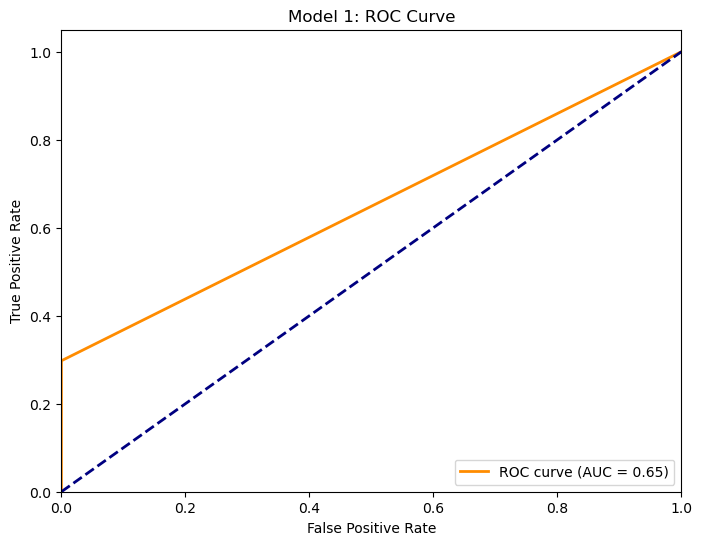

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 1: ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### Model 2: Trained without last_transaction_date column

In [37]:
y_pred = model_2.predict(df_test_all_attr)
fpr, tpr, thresholds = roc_curve(y_test_data, y_pred)
roc_auc = roc_auc_score(y_test_data, y_pred)

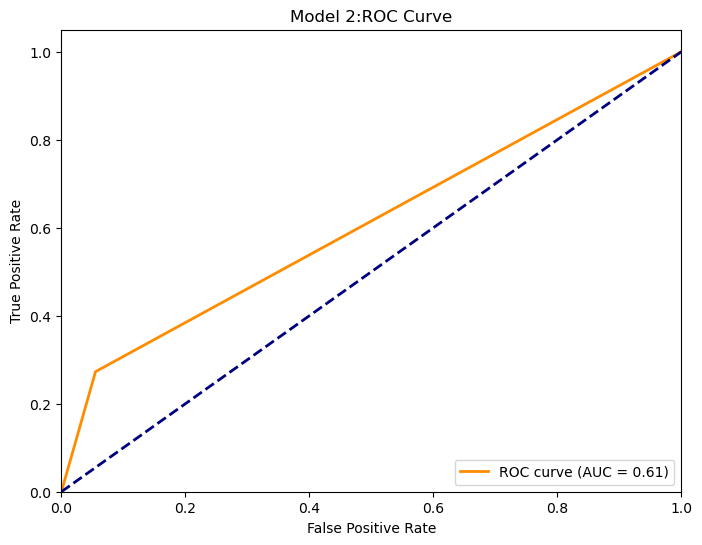

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 2:ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Feature Importance

#### Model 1: Include all attributes

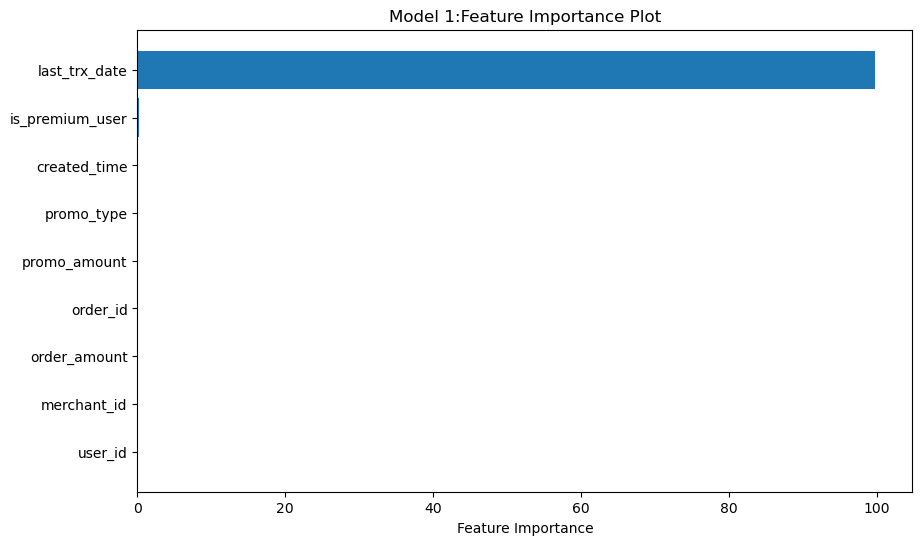

In [39]:
# Get and plot feature importance
feature_importance = model_1.get_feature_importance(type='FeatureImportance')
feature_names = df_test_all_attr.columns  # Replace with your feature names
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, align='center')
plt.xlabel('Feature Importance')
plt.title('Model 1:Feature Importance Plot')
plt.show()

#### Model 2: Trained without last_transaction_date column

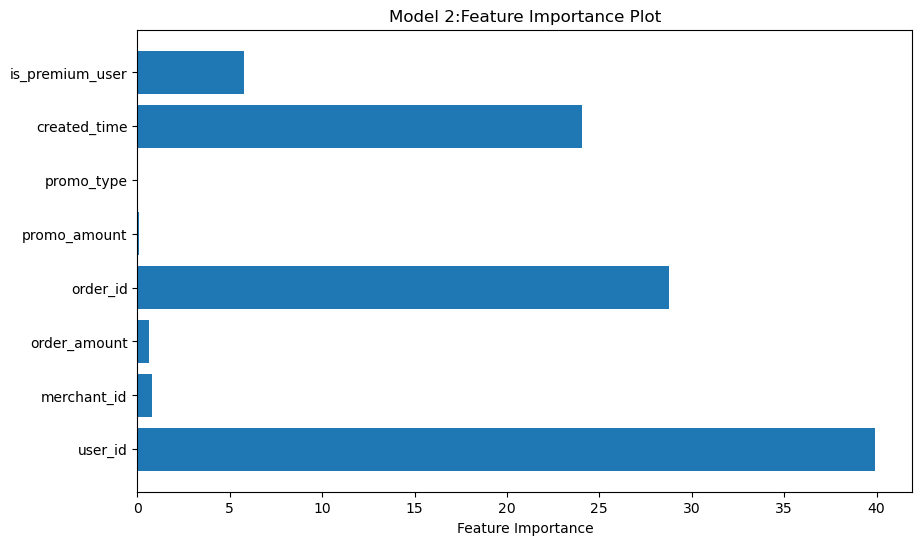

In [40]:
# Get and plot feature importance
feature_importance = model_2.get_feature_importance(type='FeatureImportance')
feature_names = df_test_all_attr.iloc[:,:-1].columns  # Replace with your feature names
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, align='center')
plt.xlabel('Feature Importance')
plt.title('Model 2:Feature Importance Plot')
plt.show()